<a href="https://colab.research.google.com/github/GwPlNicker/analyst/blob/main/skf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Анализ данных по госпитализации больных за 10 лет

# Описание данных
Каждый пациент описывается следующим набором признаков:
- `Возраст`, `Среднемесячный расход`, `Средняя продолжительность разговоров`, `Звонков днем за месяц`, `Звонков вечером за месяц`, `Звонков ночью за месяц`, `Звонки в другие города`, `Звонки в другие страны`, `Доля звонков на стационарные телефоны`, `Количество SMS за месяц`, `Дата подключения тарифа`, `Социальная категория`.

## Примерный план по выполнению проекта:
1. Загрузка данных
2. Отсев данных, не несущих информацию
3.
4.
5.
6.
7.


---
# Загружаем данные и импортируем используемые библиотеки

In [47]:
# Подключаем библиотеки пандас, нампи и работы с графиками
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Отключаем предупреждения
import warnings
from ipywidgets.widgets.widget_color import Color
warnings.filterwarnings("ignore")

# тесты для проверки гипотез о законе распределения
from scipy.stats import shapiro
from scipy.stats import kstest
from scipy.stats import ks_2samp
from scipy.stats import anderson
from scipy.stats import jarque_bera

# тесты для проверки гипотезы о равенстве параметров распределений
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal

# работа с датой
import datetime as dt

# Подключаем гугл-диск
#from google.colab import drive
#drive.mount('/content/drive')

# загружаем датафрейм
df = pd.read_csv('/content/data_skf.csv', delimiter = ';' )
df_dgn = pd.read_csv('/content/data_dgn.csv', delimiter = ';')

# Удалим лишние временные данные
#df.drop(columns=['KlKr','KlKrStd'], inplace=True)

# Просматриваем информацию о данных

In [48]:
# объявляем словарь для использования в качестве удобочитаемых заголовков
colren = {
  'Kreatinin': 'Уровень креатинина',
  'SKF': 'СКФ',
  'KlKr': 'КлКр',
  'KlKrStd': 'КлКр стандарт',
  'Pol': 'Пол',
  'Age': 'Возвраст на дату записи',
  'Region': 'Код субьекта РФ',
  'Dt_Cons': 'Дата консультации',
  'Motconsu': 'Номер записи',
  'DoB': 'Дата рождения',
  'Selo': 'Признак села',
  'Patients_ID': 'ID пациента'
 }

In [49]:
print(df.info())
print(df.columns)
#df.rename(columns=colren., inplace=True )
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210011 entries, 0 to 210010
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Kreatinin  186822 non-null  float64
 1   KlKr       112045 non-null  float64
 2   SKF        70357 non-null   float64
 3   KlKrStd    41967 non-null   float64
 4   Pol        210011 non-null  int64  
 5   Age        210009 non-null  float64
 6   Region     209856 non-null  float64
 7   Dt_Cons    210011 non-null  object 
 8   Motconsu   210011 non-null  int64  
 9   DoB        210009 non-null  object 
 10  Selo       206619 non-null  float64
dtypes: float64(7), int64(2), object(2)
memory usage: 17.6+ MB
None
Index(['Kreatinin', 'KlKr', 'SKF', 'KlKrStd', 'Pol', 'Age', 'Region',
       'Dt_Cons', 'Motconsu', 'DoB', 'Selo'],
      dtype='object')


,Kreatinin,KlKr,SKF,KlKrStd,Pol,Age,Region,Dt_Cons,Motconsu,DoB,Selo
0,85.0,112.0,98.0,97.0,0,40.0,21.0,2024-07-04 16:12:50.000,15126757,1984-01-14 00:00:00.000,0.0
1,107.0,75.0,49.0,74.0,1,60.0,13.0,2024-07-04 16:02:08.000,15126651,1964-01-04 00:00:00.000,0.0
2,65.0,117.0,84.0,92.0,1,69.0,13.0,2024-07-04 15:58:16.000,15126624,1955-10-23 00:00:00.000,0.0
3,90.0,64.0,59.0,0.0,1,62.0,41.0,2024-07-04 15:55:09.000,15126599,1962-05-24 00:00:00.000,1.0
4,84.0,84.0,61.0,70.0,1,69.0,13.0,2024-07-04 15:53:59.000,15126588,1955-04-27 00:00:00.000,1.0


# Проверяем на пустые значения

In [50]:
# Проверка на пустые значения
df.isna().sum()

Kreatinin     23189
KlKr          97966
SKF          139654
KlKrStd      168044
Pol               0
Age               2
Region          155
Dt_Cons           0
Motconsu          0
DoB               2
Selo           3392
dtype: int64

# Смотрим соответствие типов столбцов

#  Приводим типы столбцов к необходимым

In [54]:
#print(df.head(10))
col_int = ['Motconsu','Region','Pol','Selo','Age','Patients_ID']
col_dat = ['Dt_Cons','DoB']
cat_var = ['Region','Pol','Selo','Age']
for col in col_int:
  print(col, df[col].unique())
  print(col, df[col].mode()[0])

#df[cols] = df[cols].fillna(0)
#df[cols].dtypes

Motconsu [15126757 15126651 15126624 ...   564588   564558   563694]
Motconsu 1090404
Region [21 13 41 58 56 16  2 73 50 12 63 43 18 75 11 52  5 77 59 25 89 54  0 66
 48 26 46  9 36 31 30 23  8 34 80 68  3 86 19 33 78 64 61 72 24 38 67 20
 29 51 62 47 91 71 39 14 70 81 57 44 90 65 74 69 55 32 53 40 49 35 27 85
 76 37 45 83  1 87 42 10 28  7 22 15  6 79]
Region 21
Pol [0 1]
Pol 1
Selo [0 1]
Selo 0
Age [ 40  60  69  62  54  20  57  68  61  67  52  51  72  81  75  64  55  77
  82  73  63  48  59  58  56  70  74  71  76  66  46  65  41  43  49  17
  34  47  18  79  83  33  37  53  80  11  78  12  84  35  14  16  50  38
  25  85  19  44   6  45  32   8  42  15  13  39  86  36  28  87  31  21
   9   4   5  23  29  26   2  24  10  30  27   3  89  88  90  22   7 100
  93  91  98 101   1  92  94  97  96  95 120   0 117]
Age 66


расчет скф

```
IF({Пациенты.Пол}=0, {Дополнение.скд муж},
 (IF({Пациенты.Пол}=1, {Дополнение.скд жен}, null)))

 ROUND(IF({Пациенты.Пол}=0,141,144)*
DEGREE(IF({Дополнение.Уровень креатинина (мкмоль/л)}>=80 and {Пациенты.Пол}=0,1,({Дополнение.Уровень креатинина (мкмоль/л)}/IF({Пациенты.Пол}=0,79.6,61.9))),IF({Пациенты.Пол}=0,-0.411,-0.329))*
DEGREE(IF({Дополнение.Уровень креатинина (мкмоль/л)}>=80 and {Пациенты.Пол}=0,({Дополнение.Уровень креатинина (мкмоль/л)}/IF({Пациенты.Пол}=0,79.6,61.9)),1),-1.209)*
DEGREE(0.993,{Status praesens.Возраст, лет}))

ROUND(IF({Пациенты.Пол}=0,141,144)*
DEGREE(IF({Дополнение.Уровень креатинина (мкмоль/л)}<=62 and {Пациенты.Пол}=1,({Дополнение.Уровень креатинина (мкмоль/л)}/IF({Пациенты.Пол}=0,79.6,61.9)),1),IF({Пациенты.Пол}=0,-0.411,-0.329))*
DEGREE(IF({Дополнение.Уровень креатинина (мкмоль/л)}<=62 and {Пациенты.Пол}=1,1,({Дополнение.Уровень креатинина (мкмоль/л)}/IF({Пациенты.Пол}=0,79.6,61.9))),-1.209)*
DEGREE(0.993,{Status praesens.Возраст, лет}))


# Выбран кодовый формат
```



In [55]:
df[col_dat] = df[col_dat].astype('datetime64[ns]')
df[col_int] = df[col_int].fillna(0).astype(int)
# Добавляем колонку Возвраста при измерении
# Добавляем колонку возвраста на момент госпитализации
df.dtypes

Kreatinin           float64
KlKr                float64
SKF                 float64
KlKrStd             float64
Pol                   int64
Age                   int64
Region                int64
Dt_Cons      datetime64[ns]
Motconsu              int64
DoB          datetime64[ns]
Selo                  int64
dtype: object

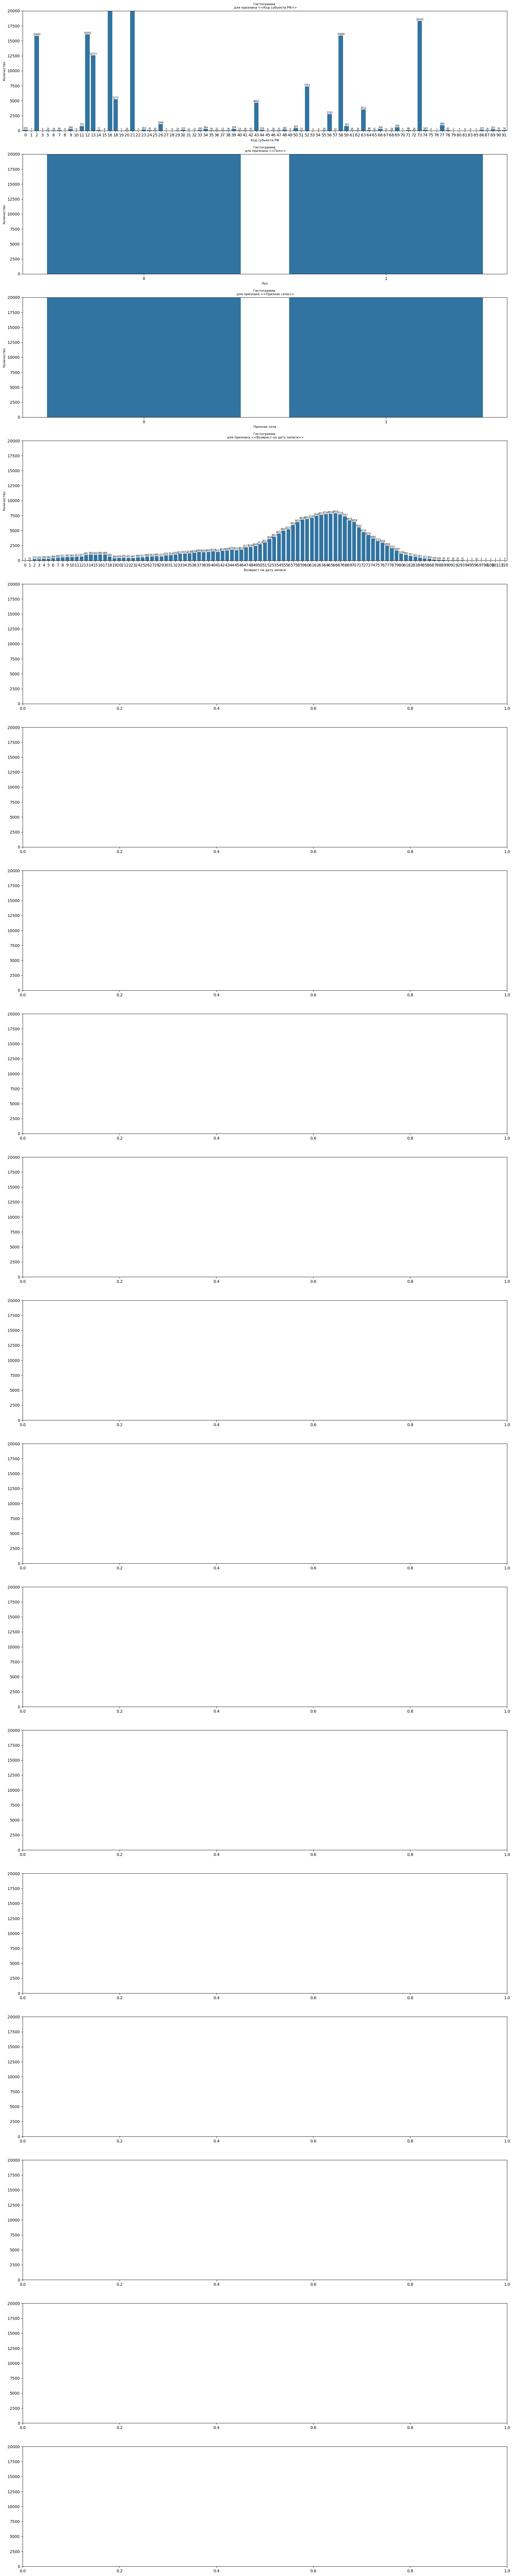

In [56]:
# 1й вариант
fig, axes = plt.subplots(18, 1, sharey=True, figsize=(18,90))
i=0
for i, col in enumerate(cat_var):
    plt.subplot(18,1,i+1)
    ax = sns.countplot(x=col, data=df,)
    plt.title("Гистограмма \n для признака <<{}>>".format(colren[col]), fontsize = 8)
    plt.xlabel(colren[col], fontsize = 8)
    plt.ylabel('Количество', fontsize = 8)
    plt.ylim(top=20000)
    plt.tight_layout()
    for pts in ax.patches:
        x=pts.get_bbox().get_points()[:,0]
        y=pts.get_bbox().get_points()[1,1]
        ax.annotate('{:.0f}'.format(pts.get_height()), (x.mean(), y), ha = 'center', va = 'bottom', fontsize = 6)


   DayCallInMon  EveningCallInMon
1         111.0             109.0
2          41.0              27.0
3          47.0              49.0
4          58.0              77.0
5          45.0              75.0
        DayCallInMon  EveningCallInMon
min         1.000000          1.000000
mean       63.907223         70.293905
median     53.000000         71.000000
max       500.000000        160.000000
   DayCallInMon  EveningCallInMon
0          53.0               3.0


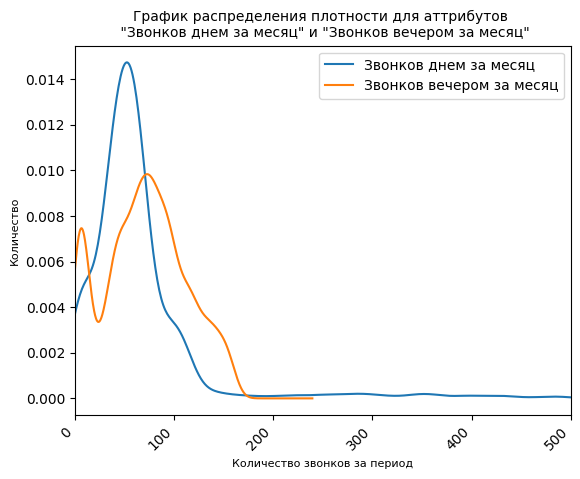

In [ ]:
# Сформулировать и проверить следующие гипотезы
#   клиенты чаще звонят днем или вечером по количеству звонков;
#   клиенты чаще звонят днем или (вечером + ночью) по количеству звонков;
#   студенты звонят чаще аспирантов ко количеству звонков;
#   клиенты больше звонили в 2019 году по сравнению с 2021 годом по количеству звонков;
#   студенты больше совершили звонков в 2019 году по сравнению с 2021 годом.
# Последовательность проверки:
#   Важно понять с какими данными мы работаем: выделяем исследуемые выборки;
#   Рассчитать точечные оценки (выборочное среднее, медиана, мода) и нарисовать графики плотности (если возможно);
#   Проверяем гипотезу о нормальности каждой из выборок.
#   Если обе выборки имеют нормальное распределение, то для проверки гипотезы о значимости их параметров необходимо применять критерий Стьюдента. В противном случае, т.е. хотя бы одна выборке не подчиняется нормальному закону, используем критерий Манна-Уитни.

# Выделим сборку
print(df[['DayCallInMon','EveningCallInMon']].head(5))
# Найдем основные функции
print( df[['DayCallInMon','EveningCallInMon']].agg(['min', pd.DataFrame.mean, pd.DataFrame.median, '':'max' ]) )
print( df[['DayCallInMon','EveningCallInMon']].mode() )


ax = df[['DayCallInMon','EveningCallInMon']].plot(kind = 'density')
plt.title('График распределения плотности для аттрибутов \n "Звонков днем за месяц" и "Звонков вечером за месяц"', fontsize = 10)
plt.xlabel('Количество звонков за период', fontsize = 8)
plt.ylabel('Количество', fontsize = 8)
plt.xticks(rotation = 45,  ha= 'right')
plt.xlim(0,500)
plt.legend(['Звонков днем за месяц', 'Звонков вечером за месяц'])



In [ ]:
# H0 - имеет нормальное распределение
# H1 - не имеет нормальное распределение
# Проверяем на нормальность с помощью критерия Шапиро
print('''
Проверка на нормальность Шапиро для "Звонков днем за месяц"\n
{}'''.format(shapiro(df['DayCallInMon'])))
print('''
Проверка на нормальность Шапиро для "Звонков вечером за месяц"\n
{}'''.format(shapiro(df['EveningCallInMon'])))
print(' pvalue < 0.05 - Распределение не соответствует нормальности')

# Проверяем на нормальность с помощью критерия Колмогорова-Смирнова
print('''
Проверка на нормальность Колмогорова-Смирнова для "Звонков днем за месяц"\n
{}'''.format( kstest(df['DayCallInMon'], 'norm', args=(df['DayCallInMon'].mean(), df['DayCallInMon'].std())) ))
print('''
Проверка на нормальность Колмогорова-Смирнова для "Звонков вечером за месяц"\n
{}'''.format( kstest(df['EveningCallInMon'], 'norm', args=(df['EveningCallInMon'].mean(), df['EveningCallInMon'].std())) ))
print(' pvalue < 0.05 - Распределение не соответствует нормальности')


# H0 : звонки днем и вечером статистически не отличаются
# H1 : звонки днем < звонков вечером, исходя из средних значений.
print('''
Тест Манна-Уитни\n
{}'''.format(mannwhitneyu(df.DayCallInMon, df.EveningCallInMon, alternative = 'less')))
print(' pvalue < 0.05 - верна гипотеза H1: вечером звонят чаще')
# Выводы в конце работы


Проверка на нормальность Шапиро для "Звонков днем за месяц"
 
ShapiroResult(statistic=0.6097855567932129, pvalue=0.0)

Проверка на нормальность Шапиро для "Звонков вечером за месяц"
 
ShapiroResult(statistic=0.9722208976745605, pvalue=1.6634125725695095e-28)
 pvalue < 0.05 - Распределение не соответствует нормальности

Проверка на нормальность Колмогорова-Смирнова для "Звонков днем за месяц"
 
KstestResult(statistic=0.24841148482932585, pvalue=2.678340502735771e-241, statistic_location=71.0, statistic_sign=1)

Проверка на нормальность Колмогорова-Смирнова для "Звонков вечером за месяц"
 
KstestResult(statistic=0.06669961597732588, pvalue=1.4032270686453868e-17, statistic_location=13.0, statistic_sign=1)
 pvalue < 0.05 - Распределение не соответствует нормальности

Тест Манна-Уитни
 
MannwhitneyuResult(statistic=7617513.0, pvalue=1.377833668305823e-74)
 pvalue < 0.05 - верна гипотеза H1: вечером звонят чаще


   DayCallInMon  EvNiCallInMon
1         111.0          110.0
2          41.0           27.0
3          47.0           49.0
4          58.0           81.0
5          45.0           78.0
        DayCallInMon  EvNiCallInMon
min         1.000000       1.000000
mean       63.907223      76.555305
median     53.000000      75.000000
max       500.000000     248.000000
   DayCallInMon  EvNiCallInMon
0          53.0            3.0


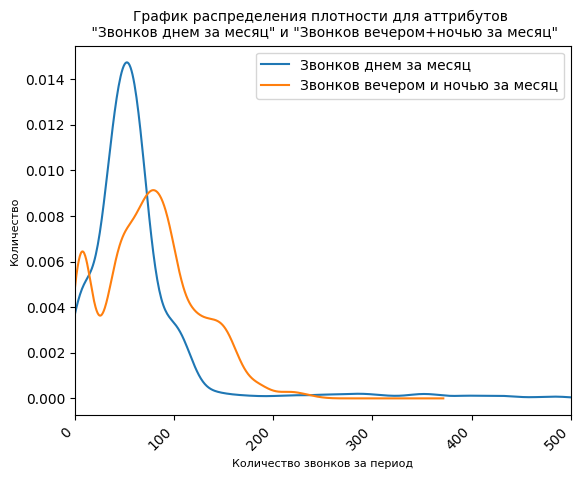

In [ ]:
# Сформулировать и проверить следующие гипотезы
#   клиенты чаще звонят днем или (вечером + ночью) по количеству звонков;
# Последовательность проверки:
#   Важно понять с какими данными мы работаем: выделяем исследуемые выборки;
#   Рассчитать точечные оценки (выборочное среднее, медиана, мода) и нарисовать графики плотности (если возможно);
#   Проверяем гипотезу о нормальности каждой из выборок.
#   Если обе выборки имеют нормальное распределение, то для проверки гипотезы о значимости их параметров необходимо применять критерий Стьюдента. В противном случае, т.е. хотя бы одна выборке не подчиняется нормальному закону, используем критерий Манна-Уитни.

# Выделим сборку
print(df[['DayCallInMon','EvNiCallInMon']].head(5))
# Найдем основные функции
print( df[['DayCallInMon','EvNiCallInMon']].agg(['min', pd.DataFrame.mean, pd.DataFrame.median, 'max' ]) )
print( df[['DayCallInMon','EvNiCallInMon']].mode() )


ax = df[['DayCallInMon','EvNiCallInMon']].plot(kind = 'density')
plt.title('График распределения плотности для аттрибутов \n "Звонков днем за месяц" и "Звонков вечером+ночью за месяц"', fontsize = 10)
plt.xlabel('Количество звонков за период', fontsize = 8)
plt.ylabel('Количество', fontsize = 8)
plt.xticks(rotation = 45,  ha= 'right')
plt.xlim(0,500)
plt.legend(['Звонков днем за месяц', 'Звонков вечером и ночью за месяц'])


In [ ]:
# среднее и медиана у ночных звонков больше чем у дневных
# H0 - имеет нормальное распределение
# H1 - не имеет нормальное распределение
# Проверяем на нормальность с помощью критерия Шапиро
print('''
Проверка на нормальность Шапиро для "Звонков днем за месяц"\n
{}'''.format(shapiro(df['DayCallInMon'])))
print('''
Проверка на нормальность Шапиро для "Звонков вечером+ночью за месяц"\n
{}'''.format(shapiro(df['EvNiCallInMon'])))
print(' pvalue < 0.05 - Распределение не соответствует нормальности')

# Проверяем на нормальность с помощью критерия Колмогорова-Смирнова
print('''
Проверка на нормальность Колмогорова-Смирнова для "Звонков днем за месяц"\n
{}'''.format( kstest(df['DayCallInMon'], 'norm', args=(df['DayCallInMon'].mean(), df['DayCallInMon'].std())) ))
print('''
Проверка на нормальность Колмогорова-Смирнова для "Звонков вечером+ночью за месяц"\n
{}'''.format( kstest(df['EvNiCallInMon'], 'norm', args=(df['EvNiCallInMon'].mean(), df['EvNiCallInMon'].std())) ))
print(' pvalue < 0.05 - Распределение не соответствует нормальности')


# H0 : звонки днем и вечером статистически не отличаются
# H1 : звонки днем < звонков вечером, исходя из средних значений.
print('''
Тест Манна-Уитни\n
{}'''.format(mannwhitneyu(df.DayCallInMon, df.EvNiCallInMon, alternative = 'less')))
print(' pvalue < 0.05 - верна гипотеза H1: вечером+ночью звонят чаще')
# Выводы в конце работы



Проверка на нормальность Шапиро для "Звонков днем за месяц"
 
ShapiroResult(statistic=0.6097855567932129, pvalue=0.0)

Проверка на нормальность Шапиро для "Звонков вечером+ночью за месяц"
 
ShapiroResult(statistic=0.9719788432121277, pvalue=1.2928023826230495e-28)
 pvalue < 0.05 - Распределение не соответствует нормальности

Проверка на нормальность Колмогорова-Смирнова для "Звонков днем за месяц"
 
KstestResult(statistic=0.24841148482932585, pvalue=2.678340502735771e-241, statistic_location=71.0, statistic_sign=1)

Проверка на нормальность Колмогорова-Смирнова для "Звонков вечером+ночью за месяц"
 
KstestResult(statistic=0.05597052354314929, pvalue=1.6705295146534765e-12, statistic_location=1.0, statistic_sign=-1)
 pvalue < 0.05 - Распределение не соответствует нормальности

Тест Манна-Уитни
 
MannwhitneyuResult(statistic=7216206.5, pvalue=1.79206243693732e-103)
 pvalue < 0.05 - верна гипотеза H1: вечером+ночью звонят чаще


['рабочий' 'аспирант' 'пенсионер' 'студент']
        AsCallInMon  StCallInMon
min       14.000000     8.000000
mean     180.115995   116.432485
median   154.000000   113.000000
max      604.000000   582.000000
   AsCallInMon  StCallInMon
0        142.0        129.0
1        146.0          NaN


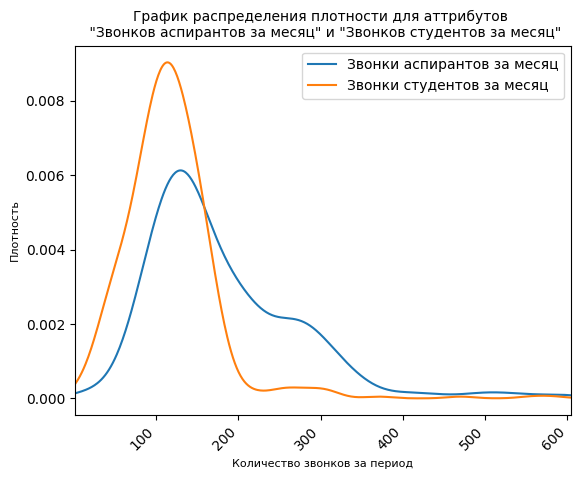

In [ ]:
# Сформулировать и проверить следующие гипотезы
#   студенты звонят чаще аспирантов ко количеству звонков;
# Последовательность проверки:
#   Важно понять с какими данными мы работаем: выделяем исследуемые выборки;
#   Рассчитать точечные оценки (выборочное среднее, медиана, мода) и нарисовать графики плотности (если возможно);
#   Проверяем гипотезу о нормальности каждой из выборок.
#   Если обе выборки имеют нормальное распределение, то для проверки гипотезы о значимости их параметров необходимо применять критерий Стьюдента. В противном случае, т.е. хотя бы одна выборке не подчиняется нормальному закону, используем критерий Манна-Уитни.

# Выделим сборку
print(df.Social.unique())
# Уникальных значений социальнйо категории 4, проще выделить нужные значения в отдельный датафрейм
df2 = pd.DataFrame()
df2['AsCallInMon'] = df[df.Social == 'аспирант']['CallInMon'].reset_index(drop= True )
df2['StCallInMon'] = df[df.Social == 'студент']['CallInMon'].reset_index(drop= True )
# Найдем основные функции
print( df2.agg(['min', pd.DataFrame.mean, pd.DataFrame.median, 'max' ]) )
print( df2.mode() )

ax = df2.plot(kind = 'density')
plt.title('График распределения плотности для аттрибутов \n "Звонков аспирантов за месяц" и "Звонков студентов за месяц"', fontsize = 10)
plt.xlabel('Количество звонков за период', fontsize = 8)
plt.ylabel('Плотность', fontsize = 8)
plt.xticks(rotation = 45,  ha= 'right')
plt.xlim(1,604)
plt.legend(['Звонки аспирантов за месяц', 'Звонки студентов за месяц'])

In [ ]:
# среднее и медиана у аспирантов больше чем у аспирантов
# H0 - имеет нормальное распределение
# H1 - не имеет нормальное распределение
# Проверяем на нормальность с помощью критерия Шапиро
print('''
Проверка на нормальность Шапиро для "Звонки аспирантов за месяц"\n
{}'''.format(shapiro(df2['AsCallInMon'].dropna())))
print(' pvalue < 0.05 - Распределение не соответствует нормальности')
print('''
Проверка на нормальность Шапиро для "Звонки студентов за месяц"\n
{}'''.format(shapiro(df2['StCallInMon'].dropna())))
print(' pvalue < 0.05 - Распределение не соответствует нормальности')

# Проверяем на нормальность с помощью критерия Колмогорова-Смирнова
print('''
Проверка на нормальность Колмогорова-Смирнова для "Звонков аспирантов за месяц"\n
{}'''.format( kstest(df2['StCallInMon'].dropna(), 'norm', args=(df2['StCallInMon'].dropna().mean(), df2['StCallInMon'].dropna().std())) ))
print(' pvalue < 0.05 - Распределение не соответствует нормальности')
print('''
Проверка на нормальность Колмогорова-Смирнова для "Звонков студентов за месяц"\n
{}'''.format( kstest(df2['StCallInMon'].dropna(), 'norm', args=(df2['StCallInMon'].dropna().mean(), df2['StCallInMon'].dropna().std())) ))
print(' pvalue < 0.05 - Распределение не соответствует нормальности')


# H0 : звонки студентов и аспирантов статистически не отличаются
# H1 : звонки студентов < аспирантов , исходя из средних значений.
print('''
Тест Манна-Уитни\n
{}'''.format(mannwhitneyu(df2['StCallInMon'], df2['AsCallInMon'], alternative = 'less', nan_policy = 'omit')))
print(' pvalue < 0.05 - верна гипотеза H1: аспиранты звонят чаще')
# Выводы в конце работы



Проверка на нормальность Шапиро для "Звонки аспирантов за месяц"
 
ShapiroResult(statistic=0.8853591084480286, pvalue=3.840669896833912e-24)
 pvalue < 0.05 - Распределение не соответствует нормальности

Проверка на нормальность Шапиро для "Звонки студентов за месяц"
 
ShapiroResult(statistic=0.806209921836853, pvalue=2.802464258968832e-24)
 pvalue < 0.05 - Распределение не соответствует нормальности

Проверка на нормальность Колмогорова-Смирнова для "Звонков аспирантов за месяц"
 
KstestResult(statistic=0.11576772377526601, pvalue=2.011880635597594e-06, statistic_location=161.0, statistic_sign=1)
 pvalue < 0.05 - Распределение не соответствует нормальности

Проверка на нормальность Колмогорова-Смирнова для "Звонков студентов за месяц"
 
KstestResult(statistic=0.11576772377526601, pvalue=2.011880635597594e-06, statistic_location=161.0, statistic_sign=1)
 pvalue < 0.05 - Распределение не соответствует нормальности

Тест Манна-Уитни
 
MannwhitneyuResult(statistic=109390.5, pvalue=6.01810

[2021 2015 2016 2017 2019 2018 2020]
             Yin19       Yin21
min       4.000000    4.000000
mean    141.969595  135.763514
median  128.000000  128.000000
max     594.000000  601.000000
   Yin19  Yin21
0  108.0   93.0
1  112.0  112.0
2    NaN  126.0
3    NaN  133.0


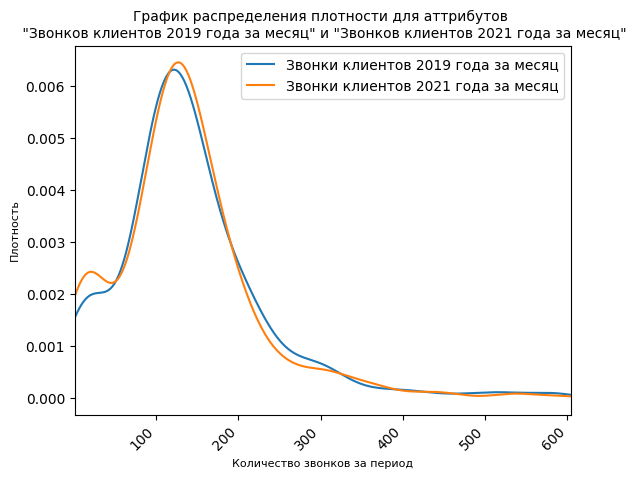

In [ ]:
# Сформулировать и проверить следующие гипотезы
#   клиенты больше звонили в 2019 году по сравнению с 2021 годом по количеству звонков;
# Последовательность проверки:
#   Важно понять с какими данными мы работаем: выделяем исследуемые выборки;
#   Рассчитать точечные оценки (выборочное среднее, медиана, мода) и нарисовать графики плотности (если возможно);
#   Проверяем гипотезу о нормальности каждой из выборок.
#   Если обе выборки имеют нормальное распределение, то для проверки гипотезы о значимости их параметров необходимо применять критерий Стьюдента. В противном случае, т.е. хотя бы одна выборке не подчиняется нормальному закону, используем критерий Манна-Уитни.

# Выделим сборку
print(df.YearIn.unique())
# Уникальных значений года заключения договора 7, проще выделить нужные значения в отдельный датафрейм
df3 = pd.DataFrame()
df3['Yin19'] = df[df.YearIn == 2019]['CallInMon'].reset_index(drop= True )
df3['Yin21'] = df[df.YearIn == 2021]['CallInMon'].reset_index(drop= True )
# Найдем основные функции
print( df3.agg(['min', pd.DataFrame.mean, pd.DataFrame.median, 'max' ]) )
print( df3.mode() )

ax = df3.plot(kind = 'density')
plt.title('График распределения плотности для аттрибутов \n "Звонков клиентов 2019 года за месяц" и "Звонков клиентов 2021 года за месяц"', fontsize = 10)
plt.xlabel('Количество звонков за период', fontsize = 8)
plt.ylabel('Плотность', fontsize = 8)
plt.xticks(rotation = 45,  ha= 'right')
plt.xlim(1,604)
plt.legend(['Звонки клиентов 2019 года за месяц', 'Звонки клиентов 2021 года за месяц'])


In [ ]:
# среднее и медиана у аспирантов больше чем у аспирантов
# H0 - имеет нормальное распределение
# H1 - не имеет нормальное распределение
# Проверяем на нормальность с помощью критерия Шапиро
print('''
Проверка на нормальность Шапиро для "Звонки клиентов 2019 года за месяц"\n
{}'''.format(shapiro(df3['Yin19'].dropna())))
print(' pvalue < 0.05 - Распределение не соответствует нормальности')
print('''
Проверка на нормальность Шапиро для "Звонки клиентов 2021 года за месяц"\n
{}'''.format(shapiro(df3['Yin21'].dropna())))
print(' pvalue < 0.05 - Распределение не соответствует нормальности')

# Проверяем на нормальность с помощью критерия Колмогорова-Смирнова
print('''
Проверка на нормальность Колмогорова-Смирнова для "Звонков клиентов 2019 года за месяц"\n
{}'''.format( kstest(df3['Yin19'].dropna(), 'norm', args=(df3['Yin19'].dropna().mean(), df3['Yin19'].dropna().std())) ))
print(' pvalue < 0.05 - Распределение не соответствует нормальности')
print('''
Проверка на нормальность Колмогорова-Смирнова для "Звонков клиентов 2021 года за месяц"\n
{}'''.format( kstest(df3['Yin21'].dropna(), 'norm', args=(df3['Yin21'].dropna().mean(), df3['Yin21'].dropna().std())) ))
print(' pvalue < 0.05 - Распределение не соответствует нормальности')


# H0 : звонки Звонков клиентов 2019 и Звонков клиентов 2021 статистически не отличаются
# H1 : звонки Звонков клиентов 2019 < Звонков клиентов 2021 , исходя из средних значений.
print('''
Тест Манна-Уитни\n
{}'''.format(mannwhitneyu(df3['Yin19'], df3['Yin21'], alternative = 'greater', nan_policy = 'omit')))
print(' pvalue > 0.05 - верна гипотеза H0: Звонки клиентов 2019 и Звонки клиентов 2021 статистически не отличаются')
# Выводы в конце работы


Проверка на нормальность Шапиро для "Звонки клиентов 2019 года за месяц"
 
ShapiroResult(statistic=0.8737098574638367, pvalue=1.7021864412887203e-21)
 pvalue < 0.05 - Распределение не соответствует нормальности

Проверка на нормальность Шапиро для "Звонки клиентов 2021 года за месяц"
 
ShapiroResult(statistic=0.8880188465118408, pvalue=2.637079096241615e-20)
 pvalue < 0.05 - Распределение не соответствует нормальности

Проверка на нормальность Колмогорова-Смирнова для "Звонков клиентов 2019 года за месяц"
 
KstestResult(statistic=0.1387062795756817, pvalue=2.1313066774156297e-10, statistic_location=158.0, statistic_sign=1)
 pvalue < 0.05 - Распределение не соответствует нормальности

Проверка на нормальность Колмогорова-Смирнова для "Звонков клиентов 2021 года за месяц"
 
KstestResult(statistic=0.1179647019343738, pvalue=1.2349315591359048e-07, statistic_location=177.0, statistic_sign=1)
 pvalue < 0.05 - Распределение не соответствует нормальности

Тест Манна-Уитни
 
MannwhitneyuResul

             Stu19       Stu21
min      23.000000   17.000000
mean    123.441176  110.516129
median  108.000000  110.500000
max     470.000000  314.000000
   Stu19  Stu21
0  108.0   51.0
1  135.0    NaN


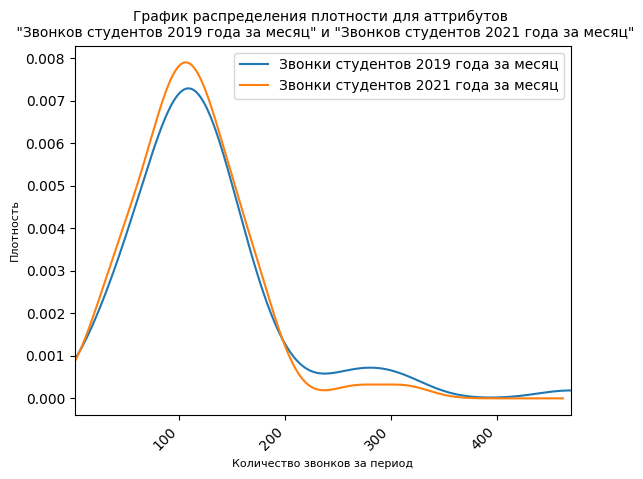

In [ ]:
# Сформулировать и проверить следующие гипотезы
#   студенты больше совершили звонков в 2019 году по сравнению с 2021 годом.
# Последовательность проверки:
#   Важно понять с какими данными мы работаем: выделяем исследуемые выборки;
#   Рассчитать точечные оценки (выборочное среднее, медиана, мода) и нарисовать графики плотности (если возможно);
#   Проверяем гипотезу о нормальности каждой из выборок.
#   Если обе выборки имеют нормальное распределение, то для проверки гипотезы о значимости их параметров необходимо применять критерий Стьюдента. В противном случае, т.е. хотя бы одна выборке не подчиняется нормальному закону, используем критерий Манна-Уитни.

# Выделим сборку, проще выделить нужные значения в отдельный датафрейм
df4 = pd.DataFrame()
df4['Stu19'] = df[(df.YearIn == 2019) & (df.Social == 'студент')]['CallInMon'].reset_index(drop= True )
df4['Stu21'] = df[(df.YearIn == 2021) & (df.Social == 'студент')]['CallInMon'].reset_index(drop= True )
# Найдем основные функции
print( df4.agg(['min', pd.DataFrame.mean, pd.DataFrame.median, 'max' ]) )
print( df4.mode() )

ax = df4.plot(kind = 'density')
plt.title('График распределения плотности для аттрибутов \n "Звонков студентов 2019 года за месяц" и "Звонков студентов 2021 года за месяц"', fontsize = 10)
plt.xlabel('Количество звонков за период', fontsize = 8)
plt.ylabel('Плотность', fontsize = 8)
plt.xticks(rotation = 45,  ha= 'right')
plt.xlim(1,470)
plt.legend(['Звонки студентов 2019 года за месяц', 'Звонки студентов 2021 года за месяц'])

In [ ]:
# среднее и медиана у аспирантов больше чем у аспирантов
# H0 - имеет нормальное распределение
# H1 - не имеет нормальное распределение
# Проверяем на нормальность с помощью критерия Шапиро
print('''
Проверка на нормальность Шапиро для "Звонки студентов 2019 года за месяц"\n
{}'''.format(shapiro(df4['Stu19'].dropna())))
print(' pvalue < 0.05 - Распределение не соответствует нормальности')
print('''
Проверка на нормальность Шапиро для "Звонки студентов 2021 года за месяц"\n
{}'''.format(shapiro(df4['Stu21'].dropna())))
print(' pvalue < 0.05 - Распределение не соответствует нормальности')

# Проверяем на нормальность с помощью критерия Колмогорова-Смирнова
print('''
Проверка на нормальность Колмогорова-Смирнова для "Звонков студентов 2019 года за месяц"\n
{}'''.format( kstest(df4['Stu19'].dropna(), 'norm', args=(df4['Stu19'].dropna().mean(), df4['Stu19'].dropna().std())) ))
print(' pvalue < 0.05 - Распределение не соответствует нормальности')
print('''
Проверка на нормальность Колмогорова-Смирнова для "Звонков студентов 2021 года за месяц"\n
{}'''.format( kstest(df4['Stu21'].dropna(), 'norm', args=(df4['Stu21'].mean(), df4['Stu21'].dropna().std())) ))
print(' pvalue < 0.05 - Распределение не соответствует нормальности')


# H0 : звонки студентов 2019 и звонки студентов 2021 статистически не отличаются
# H1 : звонки студентов 2019 > звонки студентов 2021 , исходя из средних значений.
print('''
Тест Манна-Уитни\n
{}'''.format(mannwhitneyu(df4['Stu19'], df4['Stu21'], alternative = 'greater', nan_policy = 'omit')))
print(' pvalue > 0.05 - верна гипотеза H0: звонки студентов 2019 и звонки студентов 2021 статистически не отличаются')
# Выводы в конце работы


Проверка на нормальность Шапиро для "Звонки студентов 2019 года за месяц"
 
ShapiroResult(statistic=0.8067211508750916, pvalue=5.047246887102119e-08)
 pvalue < 0.05 - Распределение не соответствует нормальности

Проверка на нормальность Шапиро для "Звонки студентов 2021 года за месяц"
 
ShapiroResult(statistic=0.9302850961685181, pvalue=0.0016740118153393269)
 pvalue < 0.05 - Распределение не соответствует нормальности

Проверка на нормальность Колмогорова-Смирнова для "Звонков студентов 2019 года за месяц"
 
KstestResult(statistic=0.185985049394223, pvalue=0.01564740345754878, statistic_location=138.0, statistic_sign=1)
 pvalue < 0.05 - Распределение не соответствует нормальности

Проверка на нормальность Колмогорова-Смирнова для "Звонков студентов 2021 года за месяц"
 
KstestResult(statistic=0.10071868881659563, pvalue=0.5227125212899479, statistic_location=123.0, statistic_sign=1)
 pvalue < 0.05 - Распределение не соответствует нормальности

Тест Манна-Уитни
 
MannwhitneyuResult(st

Сформулировать и проверить следующие гипотезы:
1.  клиенты чаще звонят днем или вечером по количеству звонков;
2.  клиенты чаще звонят днем или (вечером + ночью) по количеству звонков;
3.  студенты звонят чаще аспирантов ко количеству звонков;
4.  клиенты больше звонили в 2019 году по сравнению с 2021 годом по количеству звонков;
5.  студенты больше совершили звонков в 2019 году по сравнению с 2021 годом.

Результаты:
1.  **Клиенты чаще звонят вечером**
2.  **Клиенты чаще звонят вечером + ночью**
3.  **Аспиранты звонят чаще студентов**
4.  **Звонки клиентов 2019 и Звонки клиентов 2021 статистически не отличаются**
5.  **звонки студентов 2019 и звонки студентов 2021 статистически не отличаются**